# Plotting minimize

This Notebook plots the graphs from the minimization.

In [ ]:
# Uncomment this, if you change anything in the package
# !pip install ~/CodeRepos/threepoint_py

# External imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyccl as ccl
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy.cosmology.units as cu
from astropy.constants import G, c
from numpy.linalg import inv
from astropy.table import Table
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from cosmopower_NN_new import cosmopower_NN


In [19]:
# The following lines are needed if you have a tensorflow version >= 2.16.0, due to the keras version
import os
import sys
sys.path.insert(0, "/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL")
os.environ['TF_USE_LEGACY_KERAS'] = "1"

# Import of threepoint package
#print("\n".join(sys.path))
import threepoint_py
print(threepoint_py.__file__)

# External imports
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# If you have niceplots installed, use these lines to make the plots prettier. Otherwise, just comment them out
# import niceplots as nicepl
# nicepl.initPlot()


/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/threepoint_py/__init__.py


In [20]:
# Setting baryonification

emulatorpath=os.path.abspath('threepoint_py_GGL/threepoint_py_GGL/emulators/') # Path to trained emulators

baryon_dict = { # Dictionary with baryonification settings
        'files': {     # Files for emulators
                'powerspectrum_emulator_file':f'{emulatorpath}/powerspectra_ratio_emu_900_withk_64',
                'bispectrum_emulator_file':f'{emulatorpath}/bispectra_ratio_emu_900_withk_32'
        },
        'prior': { # Training ranges of emulators
                'k':[0.054232888,4.5135617],
                'M1_z0_cen': [9.00004692, 1.29976369e+01], 
                'M_c': [10.00264643, 1.59959142e+01], 
                'beta': [-0.99969252, 6.99793930e-01], 
                'eta': [-0.69881462, 6.99078333e-01], 
                'expfactor':[0.270535,9.99021000e-01],
                'f_b': [0.10034641, 4.99922698e-01], 
                'theta_inn': [-1.99816647, -2.14770316e-04],
                'theta_out': [0, 0.42],
                'M_inn': [9, 13.5],
            },
        'powerspec_baryonification_type': 'user' # Baryionification model for powerspectrum. Options are 'baccoemu_boost', 'user', 'None'
}
                    
baryon_parameters = { # Parameters for the baryonification
                'M1_z0_cen': 12.14888925, 
                'M_c': 13.60370478, 
                'beta': -0.22984623, 
                'eta': -0.22624365, 
                'theta_inn': -1.00156216,
                'theta_out': 0.0,
                'M_inn': np.log10(2.3e13)
}

non_linear_powerspectrum_fname = '/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/emulators/NN_emulator_PCA6_0.95_300_400n_paired_comb'


100


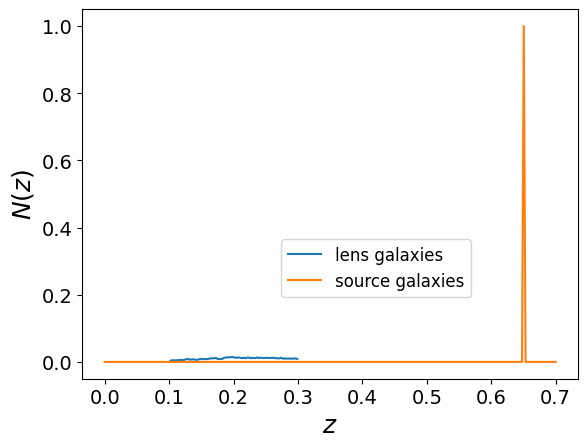

In [21]:

data = np.load("/home/akshayr/honours_thesis/School_Work/Honours_Thesis/hist.npz")
lens_nz = data['Nz']
lens_z = data['binedges'][1:]/2+data['binedges'][:-1]/2

print(len(lens_z))

source_nz = np.zeros(256) # Redshift distribution of source galaxies

source_z = np.linspace(0, 0.7, 256)
source_nz[237]=10000 

plt.xlabel('$z$',fontsize=18)
plt.ylabel('$N(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(lens_z, lens_nz/np.sum(lens_nz), label="lens galaxies")
plt.plot(source_z, source_nz/np.sum(source_nz), label="source galaxies")
plt.legend(bbox_to_anchor=(0.5, 0.1, 0.3, 0.3))
#plt.title("Redshift distribution of source and lens galaxies")
plt.show()

lens_nzs = np.array([[lens_z,lens_nz/np.sum(lens_nz)]])
source_nzs = np.array([[source_z,source_nz/np.sum(source_nz)]])

## Calculating Excess Surface Mass Density

In [22]:
h = 0.7
cosmo2 = FlatLambdaCDM(H0=100 * h, Om0=0.279, Ob0=0.046)
weights = lens_nz/sum(lens_nz)
mean_z = sum(lens_z * weights) / sum(weights)
cov = np.load("cov_T17.npy")[14:34,14:34]
dsigma_models_cos = np.load('dsigma_complete_AP_models_corrected.npy')
parameters = Table.read("parameters_4_training_100HOD.fits")
Dsigma_results = Table.read(f'dsigma_c000_ph000_hod000_seed000.fits')
#print(cov[0])

from astropy.constants import G, c
dlens=cosmo2.angular_diameter_distance(mean_z)
dsource=cosmo2.angular_diameter_distance(source_z[217])
sig_crit = c**2/(4*np.pi*G) * (dsource)/(dlens*cosmo2.angular_diameter_distance_z1z2(z1=mean_z, z2=source_z[217]))
sig_crit = sig_crit.to(u.Msun/u.Mpc**2)

fit_index_low = np.arange(0,10)
fit_index_high = np.arange(10,20)

#Considering large scales only
r_high = Dsigma_results['meanr_overh_high'][fit_index_low]
r_low = Dsigma_results['meanr_overh_low'][fit_index_low]
theta_high = r_high/(cosmo2.angular_diameter_distance(mean_z)*h)*180/np.pi
theta_low = r_low/(cosmo2.angular_diameter_distance(mean_z)*h)*180/np.pi

cov_inv_low = inv(cov[:10,:10])
cov_inv_high = inv(cov[10:,10:])


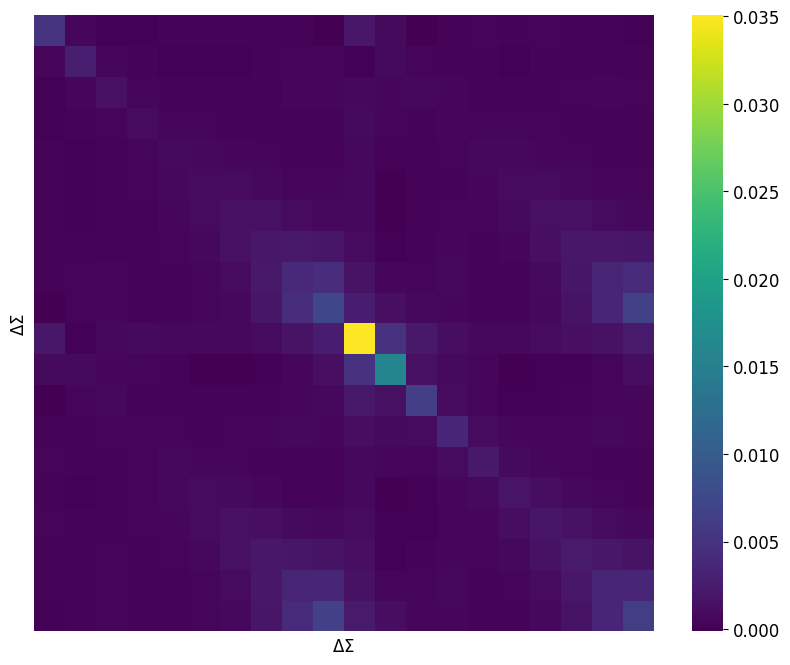

In [23]:
plt.rcParams.update({'font.size': 12})
import seaborn as sns
cov_full = np.load("cov_T17.npy")

plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(cov, cmap='viridis', annot=False, fmt=".2f", xticklabels=False, yticklabels=False)
plt.xlabel(r"$\Delta \Sigma$")
plt.ylabel(r"$\Delta \Sigma$")
plt.show()


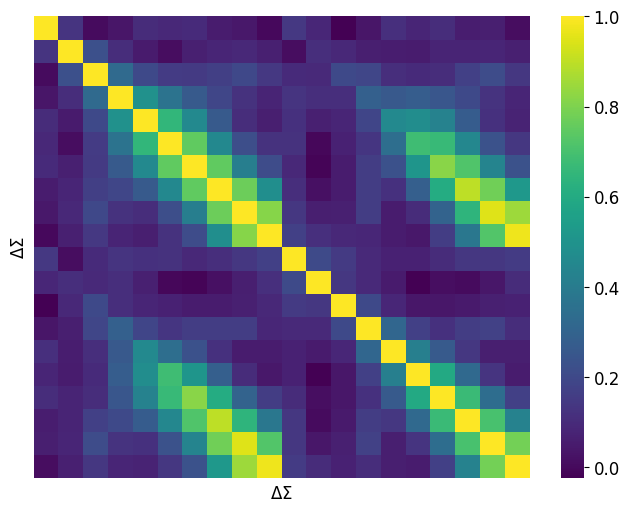

In [24]:
import numpy as np

def covariance_to_correlation(cov_matrix):
    std_dev = np.sqrt(np.diag(cov_matrix))
    outer_std_dev = np.outer(std_dev, std_dev)
    correlation_matrix = cov_matrix / outer_std_dev
    correlation_matrix[cov_matrix == 0] = 0  # To handle divisions by zero
    return correlation_matrix

# Example usage:
corr_matrix = covariance_to_correlation(cov)
# print(corr_matrix)

plt.figure(figsize=(8, 6))

sns.heatmap(corr_matrix, cmap='viridis', annot=False, fmt=".2f", xticklabels=False, yticklabels=False)
plt.xlabel(r"$\Delta \Sigma$")
plt.ylabel(r"$\Delta \Sigma$")
plt.show()


In [25]:
from numpy.linalg import inv
from astropy.table import Table
from scipy.optimize import minimize

h = 0.7
cosmo2 = FlatLambdaCDM(H0=100 * h, Om0=0.279, Ob0=0.046)
weights = lens_nz/sum(lens_nz)
mean_z = sum(lens_z * weights) / sum(weights)

from astropy.constants import G, c
dlens=cosmo2.angular_diameter_distance(mean_z)
dsource=cosmo2.angular_diameter_distance(source_z[217])
sig_crit = c**2/(4*np.pi*G) * (dsource)/(dlens*cosmo2.angular_diameter_distance_z1z2(z1=mean_z, z2=source_z[217]))
sig_crit = sig_crit.to(u.Msun/u.Mpc**2)

reference_high = []
reference_low = []
for i in range(6300):
    reference_high.append(np.array(dsigma_models_cos[i][fit_index_high]))
    reference_low.append(np.array(dsigma_models_cos[i][fit_index_low]))

def get_cosmo(params):
    cosmo=threepoint_py.cosmology_numba(h=0.7, sigma8=params["sigma8"], OmB=params["omega_b"], OmC=params["omega_cdm"], nS=params["n_s"], w=-1, 
                                               OmL=1-params["omega_b"]-params["omega_cdm"], # Cosmological parameters
                                    zmax=2.63, # Maximal redshift
                                    baryon_dict=baryon_dict, # Baryonification settings
                                    baryon_parameters=baryon_parameters, # Baryonification parameters
                                    powerspec='baccoemu', powerspec_type='non_linear',
                                    non_linear_powerspectrum_fname=non_linear_powerspectrum_fname# Power spec settings
    )
    return cosmo

def predict_vector_flexible(vals, theta, cosmo_flexible, model):
    if (vals[1] + vals[0]) < 0.1:
        return 100000*np.ones_like(theta)
    limber=threepoint_py.limber(cosmo_flexible, nz_sources=source_nzs, nz_lenses=lens_nzs, galaxy_bias_params=[[vals[0], vals[1], 10**vals[2], 10**vals[3]]], model=model)
    gammatCalculator=threepoint_py.gammat(limber=limber, nell=100)
    gammat = []
    for x in tqdm(theta):
        gammat.append(gammatCalculator.gammat(theta=float(x)/60,nell=2**15, tomo1=0,tomo2=0))
    r_esd = (gammat*sig_crit*h).to(u.Msun/u.pc**2).value
    return r_esd


In [26]:
# Importing flexible data
flexible = np.load("/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/flexible_params_all10.npz")
emulator = np.load("/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/emulator_low_params.npz")
flexible["chi2_vals"][0]
# flexible["b_flexible"][0][1]


array([660.77231119,  14.45474912])

In [27]:
emulator['b_emulator'].shape

(6300, 4)

In [ ]:
# Importing the emulator

delta_sigma_emu = cosmopower_NN(restore=True, restore_filename='/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/delta_sigma_emu')
params = np.load('/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/params_4_emualtion_notomo.npz')
para_names = params['para_names']

def predict_vector_emulator(vals, cosmo):
    if (vals[1] + vals[0]) < 0.1:
        return 100000*np.ones(10)
    
    params = {}
    for i in range(4):
        params[para_names[i]]=[cosmo[i]]
    for i in range(4,8):
        params[para_names[i]]=[vals[i-4]]
    esd=delta_sigma_emu.ten_to_rescaled_predictions_np(params)
    return esd

In [29]:
# Importing linear data
linear = np.load("/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/flexible_params_linear.npz")

b_high_linear = []
b_low_linear = []
chi2_high_linear = []
chi2_low_linear = []
for i in range(1):
    b_high_linear.append(linear['b_flexible'][i][0])
    b_low_linear.append(linear['b_flexible'][i][1])
    chi2_high_linear.append(linear['chi2_vals'][i][0])
    chi2_low_linear.append(linear['chi2_vals'][i][1])

print(b_high_linear)
print(b_low_linear)
print(chi2_high_linear)
print(chi2_low_linear)
linear["hod_chosen"]

[array([8.20945532])]
[array([2.83629715])]
[np.float64(661.0377510838061)]
[np.float64(27.934302145335575)]


array([212, 510])

Loading sigma8 emulator...


<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_118654/2654411698.py:24: SyntaxWarning: invalid escape sequence '\c'
  axis.plot(r_high, r_high*y, label=f'Flexible bias with $\chi^2={np.round(165.503, 2)}$')
/tmp/ipykernel_118654/2654411698.py:25: SyntaxWarning: invalid escape sequence '\c'
  axis.plot(r_high, r_high*y_lin, label=f'Constant bias with $\chi^2={np.round(chi2_high_linear[i], 2)}$')


Sigma8 emulator loaded in memory.
Loading linear emulator...


/home/akshayr/honours_thesis/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akshayr/honours_thesis/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Linear emulator loaded in memory.
Loading no-wiggles emulator...


/home/akshayr/honours_thesis/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No-wiggles emulator loaded in memory.
details.pickle
Loading non-linear emulator...


/home/akshayr/honours_thesis/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akshayr/honours_thesis/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.2.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akshayr/honours_thesis/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version

Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
All baryon parameters inside training range
Currently setting up D1
Currently setting up r_sigma
Currently setting up n_eff


/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/threepoint_py/limber.py:188: RuntimeWarning: divide by zero encountered in divide
  f_K_array_inv=1.0/f_K_array
/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/threepoint_py/limber.py:202: RuntimeWarning: invalid value encountered in multiply
  integrand = nz_znow * f_K_diff * f_K_array_inv[j:]


Currenty setting up ncur
Currently setting up f_k(z)
Done with precomputations
Precomputing projected powerspectrum


preparing tomo 0:   0%|                                                                 | 0/1 [00:00<?, ?it/s]/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/threepoint_py/limber.py:949: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = integrate.quad(integrand, self.zmin, self.zmax, epsrel=p_proj_epsrel)
100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.75it/s]
/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/threepoint_py/limber.py:1

Precomputing projected powerspectrum


preparing tomo 0:   0%|                                                                 | 0/1 [00:00<?, ?it/s]/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/threepoint_py/limber.py:949: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = integrate.quad(integrand, self.zmin, self.zmax, epsrel=p_proj_epsrel)
100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.58it/s]


165.51411241636012 661.0377510838061


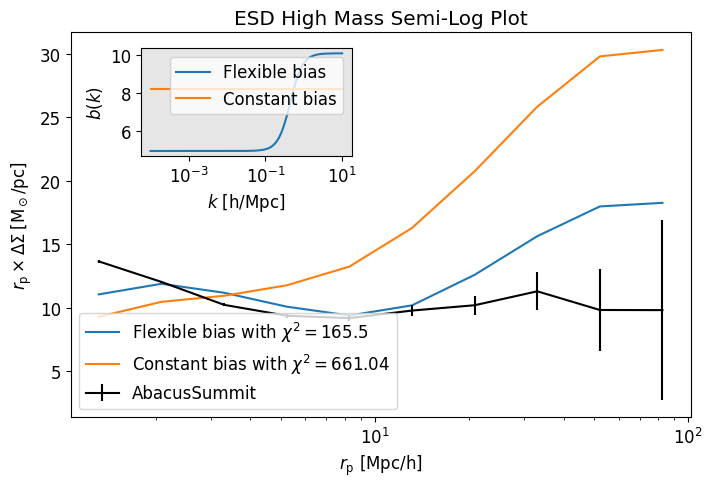

In [30]:
# Plotting the ESDs from code and AbacusSummit for 20 random HOD parameters for high stellar mass bin 
err_high = np.sqrt(np.diag(cov))[:10]

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 1, figsize=(8, 5))
# plt.rcParams.update({'font.size': 12})
hod_chosen=[212]

for i in range(1):
    cosmo_new=get_cosmo(parameters[hod_chosen[i]])
    # a = b_high_flexible[i][0]
    # c = b_high_flexible[i][1]
    # x0 = b_high_flexible[i][2]
    # n = b_high_flexible[i][3]
    
    a = -5.163
    c = 10.108
    x0 = -0.351
    n = 0.43
    # print(a,c,x0,n)
    # print(b_high_linear[i][0])
    y = predict_vector_flexible([a, c, x0, n], theta_high, cosmo_new, "flexible_offset")
    y_lin = predict_vector_flexible([0, b_high_linear[i][0], 1, 1], theta_high, cosmo_new, "flexible_offset")
    axis.plot(r_high, r_high*y, label=f'Flexible bias with $\chi^2={np.round(165.503, 2)}$')
    axis.plot(r_high, r_high*y_lin, label=f'Constant bias with $\chi^2={np.round(chi2_high_linear[i], 2)}$')

    delta = y - reference_high[hod_chosen[i]] 
    chi2  = np.matmul(delta,np.matmul(cov_inv_high,delta))
    delta_lin = y_lin - reference_high[hod_chosen[i]] 
    chi2_lin  = np.matmul(delta_lin,np.matmul(cov_inv_high,delta_lin))
    print(chi2, chi2_lin)
    axis.errorbar(r_high, r_high*reference_high[hod_chosen[i]], yerr=r_high*err_high, color='black', label="AbacusSummit")
    axis.set_title(f"ESD High Mass Semi-Log Plot")
    axis.set_xscale('log')
    # axis.set_ylim([2,27])
    axis.legend(loc=3)
    axis.set_ylabel(r'$r_{\mathrm{p}} \times \Delta \Sigma \:[\mathrm{M}_\odot/\mathrm{pc}]$')
    axis.set_xlabel(r'$r_{\mathrm{p}}$ [Mpc/h]')

    # Inserting b(k) plots
    k = np.linspace(0.0001, 10, 1000)
    bias = c + a / (1 + (k / 10**x0)**(10**n))
    bias_lin = b_high_linear[i][0]*np.ones_like(bias)
    axins = inset_axes(axis, width="40%", height="30%", bbox_to_anchor=(.1, .05, .85, .93), bbox_transform=axis.transAxes, loc="upper left")
    axins.plot(k, bias, label="Flexible bias")
    axins.plot(k, bias_lin, label="Constant bias")
    axins.set_facecolor('0.9')
    # axins.set_title(f"Bias as a Function of Wavenumber")
    axins.set_xscale('log')
    axins.legend(loc="upper right")
    axins.set_ylabel(r'$b(k)$')
    axins.set_xlabel(r'$k$ [h/Mpc]')

    
# Combine all the operations and display
plt.show()

<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_118654/662747344.py:30: SyntaxWarning: invalid escape sequence '\c'
  axis.plot(r_low, r_low*y, label=f'Flexible bias with $\chi^2={np.round(2.94, 2)}$')
/tmp/ipykernel_118654/662747344.py:31: SyntaxWarning: invalid escape sequence '\c'
  axis.plot(r_low, r_low*y_lin, label=f'Constant bias with $\chi^2={np.round(chi2_low_linear[0], 2)}$')
/tmp/ipykernel_118654/662747344.py:32: SyntaxWarning: invalid escape sequence '\c'
  axis.plot(r_low, r_low*y_emu, label=f'Flexible bias using emulator with $\chi^2={np.round(emulator["chi2_vals"][hod][0], 2)}$')


212
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...


/home/akshayr/honours_thesis/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akshayr/honours_thesis/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akshayr/honours_thesis/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.6.

Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
details.pickle
Loading non-linear emulator...


/home/akshayr/honours_thesis/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akshayr/honours_thesis/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.2.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akshayr/honours_thesis/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version

Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
All baryon parameters inside training range
Currently setting up D1
Currently setting up r_sigma
Currently setting up n_eff
Currenty setting up ncur
Currently setting up f_k(z)
Done with precomputations


/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/threepoint_py/limber.py:188: RuntimeWarning: divide by zero encountered in divide
  f_K_array_inv=1.0/f_K_array
/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/threepoint_py/limber.py:202: RuntimeWarning: invalid value encountered in multiply
  integrand = nz_znow * f_K_diff * f_K_array_inv[j:]


Precomputing projected powerspectrum


100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.40it/s]


Precomputing projected powerspectrum


100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


2.957012360566365


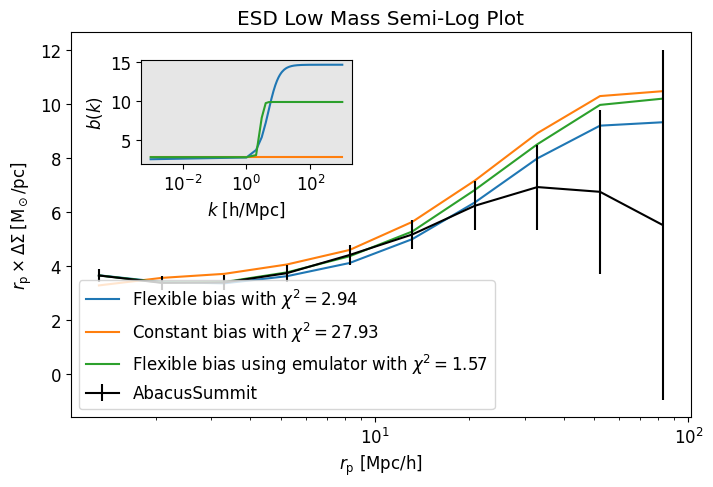

In [31]:
# Plotting the ESDs from code and AbacusSummit for 20 random HOD parameters for low stellar mass bin 
err_low = np.sqrt(np.diag(cov))[10:]

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 1, figsize=(8, 5))
# plt.rcParams.update({'font.size': 12})

for i in range(1):
    hod = 212
    print(hod)
    cosmo_new=get_cosmo(parameters[hod])
    params = parameters[hod]
    cosmo_emu = [params[1], params[-1], params[0], params[2]]
    # a = b_low_flexible[i][0]
    # c = b_low_flexible[i][1]
    # x0 = b_low_flexible[i][2]
    # n = b_low_flexible[i][3]
    # 0.13835127  0.86994056  0.02390801  1.01285921 
    a = emulator["b_emulator"][hod][0]
    c = emulator["b_emulator"][hod][1]
    x0 = emulator["b_emulator"][hod][2]
    n = emulator["b_emulator"][hod][3]
    a_int = -12.168
    c_int = 14.698
    x0_int = 0.683
    n_int = 0.403
    y_emu = predict_vector_emulator([a, c, x0, n], cosmo_emu)[0]
    y = predict_vector_flexible([a_int, c_int, x0_int, n_int], theta_low, cosmo_new, "flexible_offset")
    y_lin = predict_vector_flexible([0, b_low_linear[i][0], 1, 1], theta_low, cosmo_new, "flexible_offset")
    axis.plot(r_low, r_low*y, label=f'Flexible bias with $\chi^2={np.round(2.94, 2)}$')
    axis.plot(r_low, r_low*y_lin, label=f'Constant bias with $\chi^2={np.round(chi2_low_linear[0], 2)}$')
    axis.plot(r_low, r_low*y_emu, label=f'Flexible bias using emulator with $\chi^2={np.round(emulator["chi2_vals"][hod][0], 2)}$')

    delta = y - reference_low[hod] 
    chi2  = np.matmul(delta,np.matmul(cov_inv_low,delta))
    # delta_lin = y_lin - reference_low[hod_chosen[i]] 
    # chi2_lin  = np.matmul(delta_lin,np.matmul(cov_inv_low,delta_lin))
    print(chi2)
    axis.errorbar(r_low, r_low*reference_low[hod], yerr=r_low*err_low, color='black', label="AbacusSummit")
    axis.set_title(f"ESD Low Mass Semi-Log Plot")
    axis.set_xscale('log')
    # axis.set_ylim([-2,16])
    axis.legend(loc=3)
    axis.set_ylabel(r'$r_{\mathrm{p}} \times \Delta \Sigma \:[\mathrm{M}_\odot/\mathrm{pc}]$')
    axis.set_xlabel(r'$r_{\mathrm{p}}$ [Mpc/h]')

    # Inserting b(k) plots
    k = np.linspace(0.001, 1000, 1000)
    bias_emu = c + a / (1 + (k / 10**x0)**(10**n))
    bias_int = c_int + a_int / (1 + (k / 10**x0_int)**(10**n_int))
    bias_lin = b_low_linear[i][0]*np.ones_like(bias_int)
    axins = inset_axes(axis, width="40%", height="30%", bbox_to_anchor=(.1, .05, .85, .9), bbox_transform=axis.transAxes, loc="upper left")
    axins.plot(k, bias_int, label="Flexible bias")
    axins.set_facecolor('0.9')
    axins.plot(k, bias_lin, label="Constant bias")
    axins.plot(k, bias_emu, label="Flexible bias with emulator")
    # axins.set_title(f"Bias as a Function of Wavenumber")
    axins.set_xscale('log')
    # axins.legend(loc="upper right")
    axins.set_ylabel(r'$b(k)$')
    axins.set_xlabel(r'$k$ [h/Mpc]')
    
# Combine all the operations and display
plt.show()
# -7.10352584  9.90046447  0.43928186  1.01218263

In [32]:
HOD_2_bias_emu = cosmopower_NN(restore=True, restore_filename='/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/HOD_2_bias_emu')
emulator_low_params = np.load('/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/emulator_low_params.npz')
features = emulator_low_params['b_emulator']
chi2_vals = emulator_low_params['chi2_vals'].flatten()
valid_fits = (chi2_vals<10)&(features[:,2]>-2.5)

table_params = Table.read('parameters_4_training_100HOD.fits')[valid_fits]
para_names = table_params.colnames

train_params = {}
for i in range(len(para_names)):
    train_params[para_names[i]]=[table_params[para_names[i]][0]]


In [33]:
features.shape

(6300, 4)

In [34]:
omega_b = table_params['omega_b'][0]
omega_cdm = table_params['omega_cdm'][0]
n_s = table_params['n_s'][0]
alpha_s = table_params['alpha_s'][0]
N_ur = table_params['N_ur'][0]
w0_fld = table_params['w0_fld'][0]
wa_fld = table_params['wa_fld'][0]
log_M_0 = np.mean(table_params[para_names[7]])
log_M_1 = np.mean(table_params[para_names[8]])
gamma_1 = np.mean(table_params[para_names[9]])
gamma_2 = np.mean(table_params[para_names[10]])
sigma_c = np.mean(table_params[para_names[11]])
a_1 = np.mean(table_params[para_names[12]])
b_0 = np.mean(table_params[para_names[13]])
b_1 = np.mean(table_params[para_names[14]])
s = np.mean(table_params[para_names[15]])
Bcent = np.mean(table_params[para_names[16]])
Bsat = np.mean(table_params[para_names[17]])
sigma8 = table_params['sigma8'][0]

HOD_dict = {}
HOD_vals = [omega_b, omega_cdm, n_s, alpha_s, N_ur, w0_fld, wa_fld, log_M_0, log_M_1, gamma_1, gamma_2, sigma_c, a_1, b_0, b_1, s, Bcent, Bsat, sigma8]
for i in range(len(para_names)):
    HOD_dict[para_names[i]] = HOD_vals[i]
HOD_dict

{'omega_b': np.float64(0.02237),
 'omega_cdm': np.float64(0.12),
 'n_s': np.float64(0.9649),
 'alpha_s': np.float64(0.0),
 'N_ur': np.float64(2.0328),
 'w0_fld': np.float64(-1.0),
 'wa_fld': np.float64(0.0),
 'log_M_0': np.float64(10.485695285939496),
 'log_M_1': np.float64(10.874771956952088),
 'gamma_1': np.float64(29.003139984644502),
 'gamma_2': np.float64(0.2564388979326212),
 'sigma_c': np.float64(0.23866283730583382),
 'a_1': np.float64(9.167255265591834),
 'b_0': np.float64(-1.3868676156958133),
 'b_1': np.float64(0.10176710089738554),
 's': np.float64(0.018921119419217973),
 'Bcent': np.float64(0.19020774534804666),
 'Bsat': np.float64(-0.13268585891181034),
 'sigma8': np.float64(0.8076409582450294)}

In [35]:
table_params

omega_b,omega_cdm,n_s,alpha_s,N_ur,w0_fld,wa_fld,log_M_0,log_M_1,gamma_1,gamma_2,sigma_c,a_1,b_0,b_1,s,Bcent,Bsat,sigma8
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.966358805717523,11.491304005087555,27.758359250612166,0.1817999719492589,0.29946412972987496,2.1453257315525462,0.41764338658764455,0.46919005302180167,-1.4234982910100635,-0.9958928233790423,0.5314856535639954,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.532922403922852,10.7058129422154,45.92447608786017,0.19186430995902687,0.33087740494524165,9.526682642636866,-0.8422003040223387,0.23120780277547726,-1.1628014686756258,0.097662369654818,0.24913445889857355,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.23157113957962,10.982567547008339,24.913701696264976,0.4255928232848277,0.19103656881174852,8.199132913528521,0.20022448645538427,-0.5355911729266001,-1.133828887183359,-0.0162907139947015,-0.6272690855196106,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,11.017364504074513,11.14460742306233,20.173169748424247,0.05860146308890926,0.29937597904785007,3.380871320437387,0.19999837593928593,0.23530159874334522,-1.8308010502198506,0.6645242028582004,-1.328610920111882,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.792858689691618,10.741826764219526,34.29175670112566,0.05187645140857966,0.35521828495118485,14.358432716506421,-2.899143664007017,0.27484907331209163,0.011662662291346937,-0.2198881355954716,-0.438259923968793,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.516321874737155,11.401542304765115,18.07363238174071,0.3974197080144879,0.12836708813358771,5.965067846971224,0.8120113149949443,-0.2855143422731251,-0.6288727155422,0.1368021762236955,-1.0038571736047532,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.36421233916839,10.822874318253847,25.5109551142789,0.30254376013555206,0.22426754427547255,4.386125937217534,-0.2817391254143262,0.5498351125754813,1.4630357795445628,-0.29144002837424865,1.0257782132244855,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.866204902950157,10.856208744545519,27.815997186654464,0.10757431795326118,0.22325701732302144,12.819734069684404,-2.4348504775740167,-0.22809738614659014,0.2790021743959481,0.04368092911597432,-1.1497979703176595,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.273843709430809,10.987085716515656,20.65109048966272,0.3369503216623499,0.31157649755850964,7.308951503272822,-0.35816173710687826,0.4331973402926682,1.7129274706710782,0.46447762484369415,0.7791907775086204,0.8076409582450294


In [174]:
# plotting bias for varying s:
s_vals = np.linspace(-2, 2, 5)
train_params = {}
bias_s_vals = []
for val in s_vals:
    HOD_dict['s'] = val
    print(HOD_dict)
    for i in range(len(para_names)):
        train_params[para_names[i]]=[HOD_dict[para_names[i]]]
    bias_s_vals.append(HOD_2_bias_emu.rescaled_predictions_np(train_params)[0])

HOD_dict['s'] = np.mean(table_params[para_names[15]])
print(bias_s_vals[0])
print(bias_s_vals[1])
print(bias_s_vals[2])
print(bias_s_vals[3])
print(bias_s_vals[4])

{'omega_b': np.float64(0.02237), 'omega_cdm': np.float64(0.12), 'n_s': np.float64(0.9649), 'alpha_s': np.float64(0.0), 'N_ur': np.float64(2.0328), 'w0_fld': np.float64(-1.0), 'wa_fld': np.float64(0.0), 'log_M_0': np.float64(10.485695285939496), 'log_M_1': np.float64(10.874771956952088), 'gamma_1': np.float64(29.003139984644502), 'gamma_2': np.float64(0.2564388979326212), 'sigma_c': np.float64(0.23866283730583382), 'a_1': np.float64(9.167255265591834), 'b_0': np.float64(-1.3868676156958133), 'b_1': np.float64(0.10176710089738554), 's': np.float64(-2.0), 'Bcent': np.float64(0.19020774534804666), 'Bsat': np.float64(-0.13268585891181034), 'sigma8': np.float64(0.8076409582450294)}
{'omega_b': np.float64(0.02237), 'omega_cdm': np.float64(0.12), 'n_s': np.float64(0.9649), 'alpha_s': np.float64(0.0), 'N_ur': np.float64(2.0328), 'w0_fld': np.float64(-1.0), 'wa_fld': np.float64(0.0), 'log_M_0': np.float64(10.485695285939496), 'log_M_1': np.float64(10.874771956952088), 'gamma_1': np.float64(29.00

In [175]:
# plotting bias for varying Bcent:
Bcent_vals = np.linspace(-1, 1, 5)
train_params = {}
bias_Bcent_vals = []
for val in Bcent_vals:
    HOD_dict['Bcent'] = val
    print(HOD_dict)
    for i in range(len(para_names)):
        train_params[para_names[i]]=[HOD_dict[para_names[i]]]
    bias_Bcent_vals.append(HOD_2_bias_emu.rescaled_predictions_np(train_params)[0])

HOD_dict['Bcent'] = np.mean(table_params[para_names[16]])
bias_Bcent_vals

{'omega_b': np.float64(0.02237), 'omega_cdm': np.float64(0.12), 'n_s': np.float64(0.9649), 'alpha_s': np.float64(0.0), 'N_ur': np.float64(2.0328), 'w0_fld': np.float64(-1.0), 'wa_fld': np.float64(0.0), 'log_M_0': np.float64(10.485695285939496), 'log_M_1': np.float64(10.874771956952088), 'gamma_1': np.float64(29.003139984644502), 'gamma_2': np.float64(0.2564388979326212), 'sigma_c': np.float64(0.23866283730583382), 'a_1': np.float64(9.167255265591834), 'b_0': np.float64(-1.3868676156958133), 'b_1': np.float64(0.10176710089738554), 's': np.float64(0.018921119419217973), 'Bcent': np.float64(-1.0), 'Bsat': np.float64(-0.13268585891181034), 'sigma8': np.float64(0.8076409582450294)}
{'omega_b': np.float64(0.02237), 'omega_cdm': np.float64(0.12), 'n_s': np.float64(0.9649), 'alpha_s': np.float64(0.0), 'N_ur': np.float64(2.0328), 'w0_fld': np.float64(-1.0), 'wa_fld': np.float64(0.0), 'log_M_0': np.float64(10.485695285939496), 'log_M_1': np.float64(10.874771956952088), 'gamma_1': np.float64(29.0

[array([-8.18594978, 11.04843835,  0.46891785,  2.61191816]),
 array([-7.99437117, 11.08683345,  0.45159487,  3.1441379 ]),
 array([-8.36512061, 10.82602259,  0.55101919,  1.34509749]),
 array([-9.64373403, 11.43797378,  0.53238123,  3.1484442 ]),
 array([-10.89398163,  12.60484703,   0.29102385,   3.50988796])]

In [176]:
# plotting bias for varying Bsat:
Bsat_vals = np.linspace(-2, 2, 7)
train_params = {}
bias_Bsat_vals = []
for val in Bsat_vals:
    HOD_dict['Bsat'] = val
    print(HOD_dict)
    for i in range(len(para_names)):
        train_params[para_names[i]]=[HOD_dict[para_names[i]]]
    bias_Bsat_vals.append(HOD_2_bias_emu.rescaled_predictions_np(train_params)[0])

HOD_dict['Bsat'] = np.mean(table_params[para_names[17]])
bias_Bsat_vals

{'omega_b': np.float64(0.02237), 'omega_cdm': np.float64(0.12), 'n_s': np.float64(0.9649), 'alpha_s': np.float64(0.0), 'N_ur': np.float64(2.0328), 'w0_fld': np.float64(-1.0), 'wa_fld': np.float64(0.0), 'log_M_0': np.float64(10.485695285939496), 'log_M_1': np.float64(10.874771956952088), 'gamma_1': np.float64(29.003139984644502), 'gamma_2': np.float64(0.2564388979326212), 'sigma_c': np.float64(0.23866283730583382), 'a_1': np.float64(9.167255265591834), 'b_0': np.float64(-1.3868676156958133), 'b_1': np.float64(0.10176710089738554), 's': np.float64(0.018921119419217973), 'Bcent': np.float64(0.19020774534804666), 'Bsat': np.float64(-2.0), 'sigma8': np.float64(0.8076409582450294)}
{'omega_b': np.float64(0.02237), 'omega_cdm': np.float64(0.12), 'n_s': np.float64(0.9649), 'alpha_s': np.float64(0.0), 'N_ur': np.float64(2.0328), 'w0_fld': np.float64(-1.0), 'wa_fld': np.float64(0.0), 'log_M_0': np.float64(10.485695285939496), 'log_M_1': np.float64(10.874771956952088), 'gamma_1': np.float64(29.00

[array([-8.82196663, 11.026756  ,  0.30216507,  4.92774387]),
 array([-7.81516633, 10.09983818,  0.58073381,  2.27572033]),
 array([-8.92213734, 11.14495243,  0.65642797,  1.00353942]),
 array([-9.01706362, 11.38054712,  0.60325713,  1.10385641]),
 array([-8.9260167 , 11.69386114,  0.51400482,  1.5658952 ]),
 array([-8.64721213, 11.70842237,  0.43560107,  2.10591558]),
 array([-8.29741245, 11.38145094,  0.46407523,  2.14514488])]

In [177]:
# plotting bias for varying log_M_0:
log_M_0_vals = np.linspace(10.2, 10.8, 5)
train_params = {}
bias_log_M_0_vals = []
for val in log_M_0_vals:
    HOD_dict['log_M_0'] = val
    print(HOD_dict)
    for i in range(len(para_names)):
        train_params[para_names[i]]=[HOD_dict[para_names[i]]]
    bias_log_M_0_vals.append(HOD_2_bias_emu.rescaled_predictions_np(train_params)[0])

HOD_dict['log_M_0'] = np.mean(table_params[para_names[7]])
bias_log_M_0_vals

{'omega_b': np.float64(0.02237), 'omega_cdm': np.float64(0.12), 'n_s': np.float64(0.9649), 'alpha_s': np.float64(0.0), 'N_ur': np.float64(2.0328), 'w0_fld': np.float64(-1.0), 'wa_fld': np.float64(0.0), 'log_M_0': np.float64(10.2), 'log_M_1': np.float64(10.874771956952088), 'gamma_1': np.float64(29.003139984644502), 'gamma_2': np.float64(0.2564388979326212), 'sigma_c': np.float64(0.23866283730583382), 'a_1': np.float64(9.167255265591834), 'b_0': np.float64(-1.3868676156958133), 'b_1': np.float64(0.10176710089738554), 's': np.float64(0.018921119419217973), 'Bcent': np.float64(0.19020774534804666), 'Bsat': np.float64(-0.13268585891181034), 'sigma8': np.float64(0.8076409582450294)}
{'omega_b': np.float64(0.02237), 'omega_cdm': np.float64(0.12), 'n_s': np.float64(0.9649), 'alpha_s': np.float64(0.0), 'N_ur': np.float64(2.0328), 'w0_fld': np.float64(-1.0), 'wa_fld': np.float64(0.0), 'log_M_0': np.float64(10.35), 'log_M_1': np.float64(10.874771956952088), 'gamma_1': np.float64(29.0031399846445

[array([-12.49675703,  15.284911  ,   0.63820772,   0.64806988]),
 array([-10.39087054,  12.78315562,   0.57473656,   1.48907964]),
 array([-8.95255233, 11.25685293,  0.62626024,  1.05008823]),
 array([-9.18779138, 11.52443677,  0.63501032,  1.66106967]),
 array([-10.43753312,  12.68200995,   0.5934894 ,   2.37847421])]

In [178]:
# plotting bias for varying log_M_1:
log_M_1_vals = np.linspace(10.6, 11.5, 5)
train_params = {}
bias_log_M_1_vals = []
for val in log_M_1_vals:
    HOD_dict['log_M_1'] = val
    print(HOD_dict)
    for i in range(len(para_names)):
        train_params[para_names[i]]=[HOD_dict[para_names[i]]]
    bias_log_M_1_vals.append(HOD_2_bias_emu.rescaled_predictions_np(train_params)[0])

HOD_dict['log_M_1'] = np.mean(table_params[para_names[8]])
bias_log_M_1_vals

{'omega_b': np.float64(0.02237), 'omega_cdm': np.float64(0.12), 'n_s': np.float64(0.9649), 'alpha_s': np.float64(0.0), 'N_ur': np.float64(2.0328), 'w0_fld': np.float64(-1.0), 'wa_fld': np.float64(0.0), 'log_M_0': np.float64(10.485695285939496), 'log_M_1': np.float64(10.6), 'gamma_1': np.float64(29.003139984644502), 'gamma_2': np.float64(0.2564388979326212), 'sigma_c': np.float64(0.23866283730583382), 'a_1': np.float64(9.167255265591834), 'b_0': np.float64(-1.3868676156958133), 'b_1': np.float64(0.10176710089738554), 's': np.float64(0.018921119419217973), 'Bcent': np.float64(0.19020774534804666), 'Bsat': np.float64(-0.13268585891181034), 'sigma8': np.float64(0.8076409582450294)}
{'omega_b': np.float64(0.02237), 'omega_cdm': np.float64(0.12), 'n_s': np.float64(0.9649), 'alpha_s': np.float64(0.0), 'N_ur': np.float64(2.0328), 'w0_fld': np.float64(-1.0), 'wa_fld': np.float64(0.0), 'log_M_0': np.float64(10.485695285939496), 'log_M_1': np.float64(10.825), 'gamma_1': np.float64(29.003139984644

[array([-9.53939642, 11.95904142,  0.55203586,  2.59730108]),
 array([-8.80146661, 11.10868874,  0.63244898,  1.1410938 ]),
 array([-10.53170003,  13.05607357,   0.5061307 ,   1.241881  ]),
 array([-11.62374137,  14.88513386,   0.43860146,   1.62528466]),
 array([-14.12601528,  18.18755082,   0.18589987,   1.16387289])]

In [179]:
# plotting bias for varying sigma8:
sigma8_vals = np.linspace(0.7, 0.9, 5)
train_params = {}
bias_sigma8_vals = []
for val in sigma8_vals:
    HOD_dict['sigma8'] = val
    print(HOD_dict)
    for i in range(len(para_names)):
        train_params[para_names[i]]=[HOD_dict[para_names[i]]]
    bias_sigma8_vals.append(HOD_2_bias_emu.rescaled_predictions_np(train_params)[0])

HOD_dict['sigma8'] = np.mean(table_params[para_names[-1]])
para_names
HOD_dict

{'omega_b': np.float64(0.02237), 'omega_cdm': np.float64(0.12), 'n_s': np.float64(0.9649), 'alpha_s': np.float64(0.0), 'N_ur': np.float64(2.0328), 'w0_fld': np.float64(-1.0), 'wa_fld': np.float64(0.0), 'log_M_0': np.float64(10.485695285939496), 'log_M_1': np.float64(10.874771956952088), 'gamma_1': np.float64(29.003139984644502), 'gamma_2': np.float64(0.2564388979326212), 'sigma_c': np.float64(0.23866283730583382), 'a_1': np.float64(9.167255265591834), 'b_0': np.float64(-1.3868676156958133), 'b_1': np.float64(0.10176710089738554), 's': np.float64(0.018921119419217973), 'Bcent': np.float64(0.19020774534804666), 'Bsat': np.float64(-0.13268585891181034), 'sigma8': np.float64(0.7)}
{'omega_b': np.float64(0.02237), 'omega_cdm': np.float64(0.12), 'n_s': np.float64(0.9649), 'alpha_s': np.float64(0.0), 'N_ur': np.float64(2.0328), 'w0_fld': np.float64(-1.0), 'wa_fld': np.float64(0.0), 'log_M_0': np.float64(10.485695285939496), 'log_M_1': np.float64(10.874771956952088), 'gamma_1': np.float64(29.0

{'omega_b': np.float64(0.02237),
 'omega_cdm': np.float64(0.12),
 'n_s': np.float64(0.9649),
 'alpha_s': np.float64(0.0),
 'N_ur': np.float64(2.0328),
 'w0_fld': np.float64(-1.0),
 'wa_fld': np.float64(0.0),
 'log_M_0': np.float64(10.485695285939496),
 'log_M_1': np.float64(10.874771956952088),
 'gamma_1': np.float64(29.003139984644502),
 'gamma_2': np.float64(0.2564388979326212),
 'sigma_c': np.float64(0.23866283730583382),
 'a_1': np.float64(9.167255265591834),
 'b_0': np.float64(-1.3868676156958133),
 'b_1': np.float64(0.10176710089738554),
 's': np.float64(0.018921119419217973),
 'Bcent': np.float64(0.19020774534804666),
 'Bsat': np.float64(-0.13268585891181034),
 'sigma8': np.float64(0.8011062227770673)}

/tmp/ipykernel_118654/3624802426.py:11: RuntimeWarning: overflow encountered in power
  return c + a / (1 + (x / 10**x0)**(10**n))


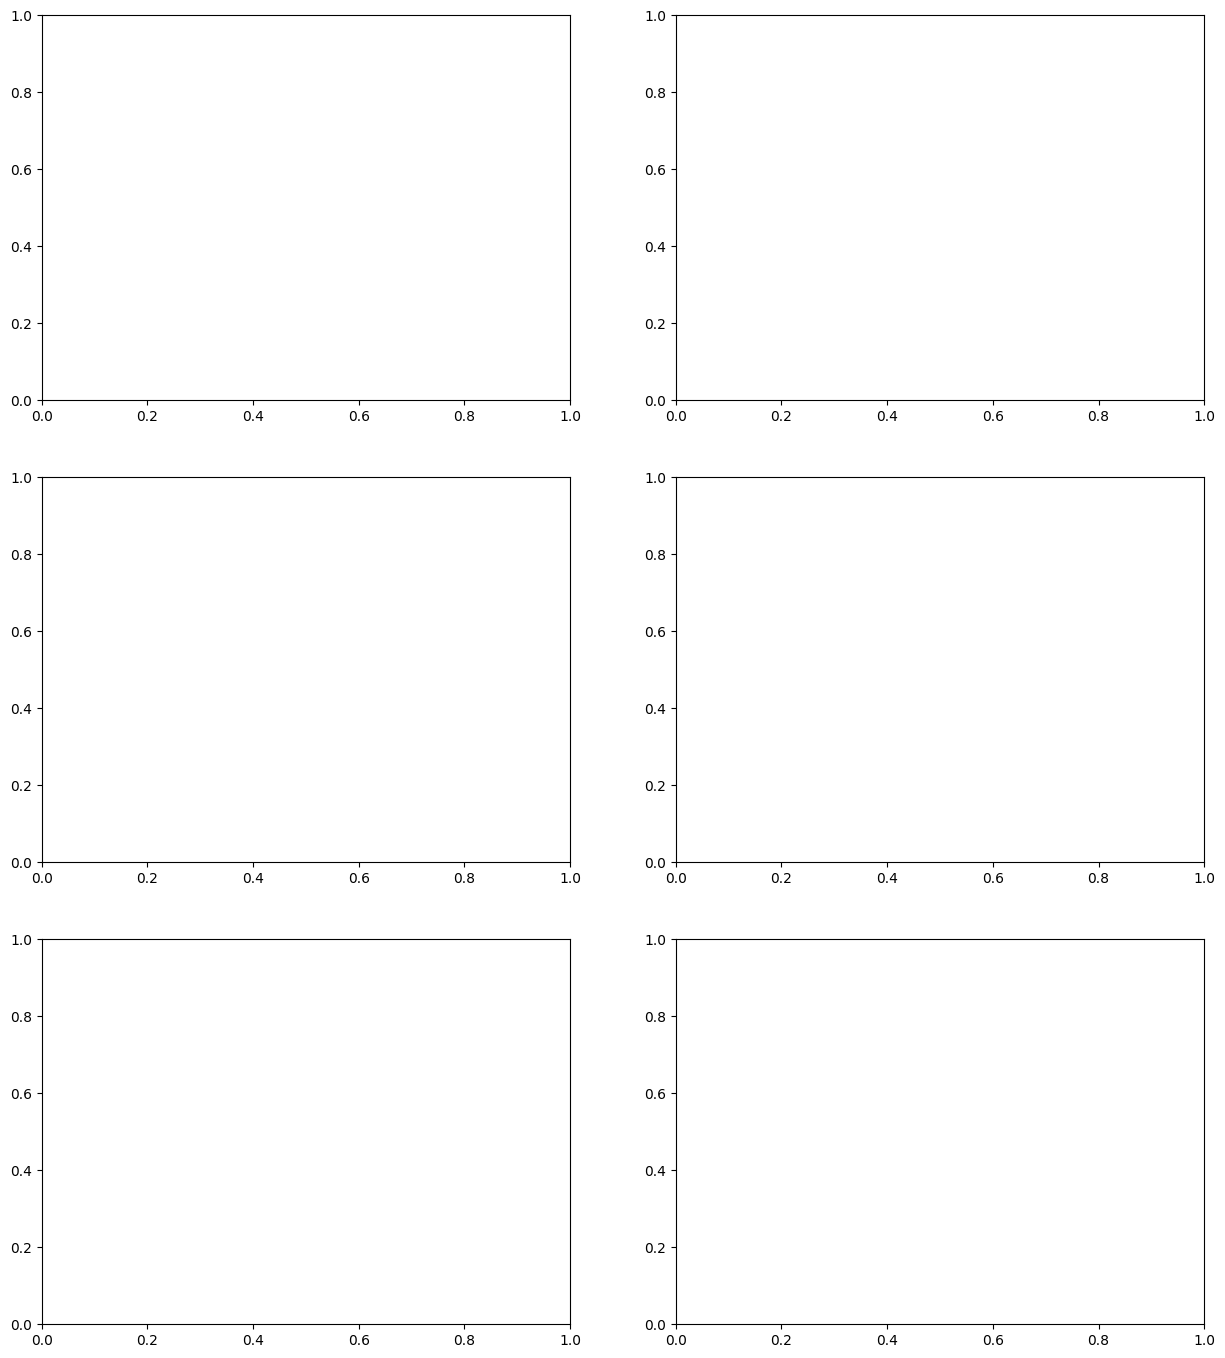

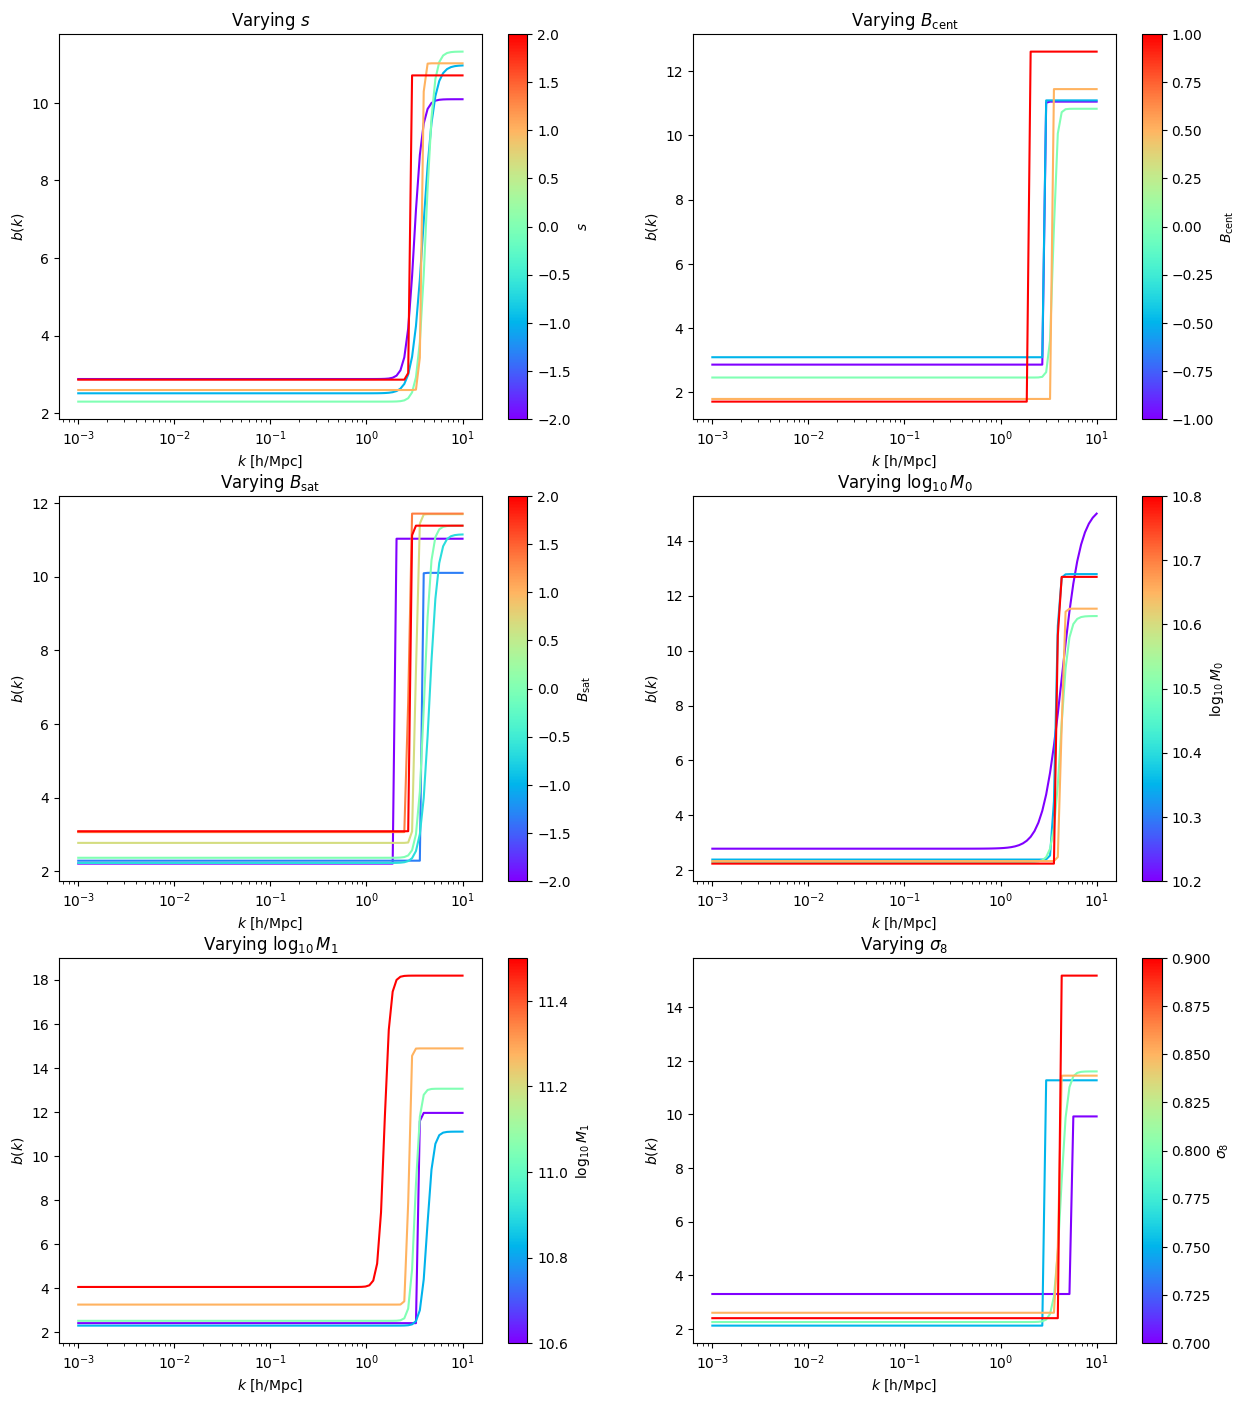

In [180]:
mpl.rcParams.update(mpl.rcParamsDefault)
# Define the function
def flexible(x, a, c, x0, n):
    """
    Flexible function that does not converge to zero.
    - x0: transition point
    - n: sharpness of transition
    - a: amplitude factor
    - c: asymptotic offset
    """
    return c + a / (1 + (x / 10**x0)**(10**n))

# Parameters
# Define the range for x
x = np.logspace(np.log10(0.001),np.log10(10),100)

# Function to add colorbar
def add_colorbar(ax, sm, label):
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(label)

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 17))
# plt.rcParams.update({'font.size': 12})

norm = Normalize(vmin=s_vals.min(), vmax=s_vals.max())
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
for i in range(len(s_vals)):
    y = flexible(x, bias_s_vals[i][0], bias_s_vals[i][1], bias_s_vals[i][2], bias_s_vals[i][3])
    axes[0, 0].plot(x, y, label=f's={s_vals[i]:.2f}', color=plt.cm.rainbow((s_vals[i] - s_vals.min()) / (s_vals.max() - s_vals.min())))
add_colorbar(axes[0, 0], sm, r'$s$')
axes[0, 0].set_title(r'Varying $s$')
axes[0, 0].set_xlabel(r'$k$ [h/Mpc]')
axes[0, 0].set_ylabel(r'$b(k)$')
axes[0, 0].set_xscale('log')

norm = Normalize(vmin=Bcent_vals.min(), vmax=Bcent_vals.max())
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
for i in range(len(Bcent_vals)):
    y = flexible(x, bias_Bcent_vals[i][0], bias_Bcent_vals[i][1], bias_Bcent_vals[i][2], bias_Bcent_vals[i][3])
    axes[0, 1].plot(x, y, label=f's={Bcent_vals[i]:.2f}', color=plt.cm.rainbow((Bcent_vals[i] - Bcent_vals.min()) / (Bcent_vals.max() - Bcent_vals.min())))
add_colorbar(axes[0, 1], sm, r'$B_\mathrm{cent}$')
axes[0, 1].set_title(r'Varying $B_\mathrm{cent}$')
axes[0, 1].set_xlabel(r'$k$ [h/Mpc]')
axes[0, 1].set_ylabel(r'$b(k)$')
axes[0, 1].set_xscale('log')

norm = Normalize(vmin=Bsat_vals.min(), vmax=Bsat_vals.max())
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
for i in range(len(Bsat_vals)):
    y = flexible(x, bias_Bsat_vals[i][0], bias_Bsat_vals[i][1], bias_Bsat_vals[i][2], bias_Bsat_vals[i][3])
    axes[1, 0].plot(x, y, label=f's={Bsat_vals[i]:.2f}', color=plt.cm.rainbow((Bsat_vals[i] - Bsat_vals.min()) / (Bsat_vals.max() - Bsat_vals.min())))
add_colorbar(axes[1, 0], sm, r'$B_\mathrm{sat}$')
axes[1, 0].set_title(r'Varying $B_\mathrm{sat}$')
axes[1, 0].set_xlabel(r'$k$ [h/Mpc]')
axes[1, 0].set_ylabel(r'$b(k)$')
axes[1, 0].set_xscale('log')

norm = Normalize(vmin=log_M_0_vals.min(), vmax=log_M_0_vals.max())
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
for i in range(len(log_M_0_vals)):
    y = flexible(x, bias_log_M_0_vals[i][0], bias_log_M_0_vals[i][1], bias_log_M_0_vals[i][2], bias_log_M_0_vals[i][3])
    axes[1, 1].plot(x, y, label=f's={log_M_0_vals[i]:.2f}', color=plt.cm.rainbow((log_M_0_vals[i] - log_M_0_vals.min()) / (log_M_0_vals.max() - log_M_0_vals.min())))
add_colorbar(axes[1, 1], sm, r'$\log_{10} M_0$')
axes[1, 1].set_title(r'Varying $\log_{10} M_0$')
axes[1, 1].set_xlabel(r'$k$ [h/Mpc]')
axes[1, 1].set_ylabel(r'$b(k)$')
axes[1, 1].set_xscale('log')

norm = Normalize(vmin=log_M_1_vals.min(), vmax=log_M_1_vals.max())
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
for i in range(len(log_M_1_vals)):
    y = flexible(x, bias_log_M_1_vals[i][0], bias_log_M_1_vals[i][1], bias_log_M_1_vals[i][2], bias_log_M_1_vals[i][3])
    axes[2, 0].plot(x, y, label=f's={log_M_1_vals[i]:.2f}', color=plt.cm.rainbow((log_M_1_vals[i] - log_M_1_vals.min()) / (log_M_1_vals.max() - log_M_1_vals.min())))
add_colorbar(axes[2, 0], sm,  r'$\log_{10} M_1$')
axes[2, 0].set_title(r'Varying $\log_{10} M_1$')
axes[2, 0].set_xlabel(r'$k$ [h/Mpc]')
axes[2, 0].set_ylabel(r'$b(k)$')
axes[2, 0].set_xscale('log')

norm = Normalize(vmin=sigma8_vals.min(), vmax=sigma8_vals.max())
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
for i in range(len(sigma8_vals)):
    y = flexible(x, bias_sigma8_vals[i][0], bias_sigma8_vals[i][1], bias_sigma8_vals[i][2], bias_sigma8_vals[i][3])
    axes[2, 1].plot(x, y, label=f's={sigma8_vals[i]:.2f}', color=plt.cm.rainbow((sigma8_vals[i] - sigma8_vals.min()) / (sigma8_vals.max() - sigma8_vals.min())))
add_colorbar(axes[2, 1], sm, r'$\sigma_8$')
axes[2, 1].set_title(r'Varying $\sigma_8$')
axes[2, 1].set_xlabel(r'$k$ [h/Mpc]')
axes[2, 1].set_ylabel(r'$b(k)$')
axes[2, 1].set_xscale('log')

plt.show()

In [95]:
params = np.load('/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/params_4_emualtion_notomo.npz')
para_names_short = params['para_names']

def predict_vector_emulator(vals, cosmo):
    if (vals[1] + vals[0]) < 0.1:
        return 100000*np.ones(10)
    
    bias_params = {}
    for i in range(4):
        bias_params[para_names_short[i]]=[cosmo[i]]
    for i in range(4,8):
        bias_params[para_names_short[i]]=[vals[i-4]]
    esd=delta_sigma_emu.ten_to_rescaled_predictions_np(bias_params)
    return esd

In [155]:
# use mapping emulator to obtain bias params for each HOD combination
# use ESD emulator to map bias to ESD
# obtain chi2 values by comparing to abacussummit
emulator_low_params = np.load('/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/emulator_low_params.npz')
features = emulator_low_params['b_emulator']
chi2_vals = emulator_low_params['chi2_vals'].flatten()
valid_fits = (chi2_vals<10)&(features[:,2]>-2.5)
table_params = Table.read('/home/akshayr/honours_thesis/School_Work/Honours_Thesis/parameters_4_training_100HOD.fits')[valid_fits]
para_names = table_params.colnames

HOD_2_bias_emu = cosmopower_NN(restore=True, restore_filename='/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/HOD_2_bias_emu')

HOD_filtered_params = {}
for i in range(len(para_names)):
    HOD_filtered_params[para_names[i]]=table_params[para_names[i]]

bias_emu_pred=HOD_2_bias_emu.rescaled_predictions_np(HOD_filtered_params)
delta_sigma_emu = cosmopower_NN(restore=True, restore_filename='/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/delta_sigma_emu')

bias_cosmology =bias_emu_pred.T

esds = []
for i in range(len(bias_cosmology[0])):
    cosmo_emu = [table_params["omega_cdm"][i], table_params["sigma8"][i], table_params["omega_b"][i], table_params["n_s"][i]]
    y = predict_vector_emulator([bias_cosmology[0][i], bias_cosmology[1][i], bias_cosmology[2][i], bias_cosmology[3][i]], cosmo_emu)[0]
    esds.append(y)

new_reference = np.array(reference_low)[valid_fits]
chi2_vals = []
for i in range(len(new_reference)):
    delta = esds[i] - new_reference[i] 
    chi2 = np.matmul(delta,np.matmul(cov_inv_low,delta))
    chi2_vals.append(chi2)




4201
4157


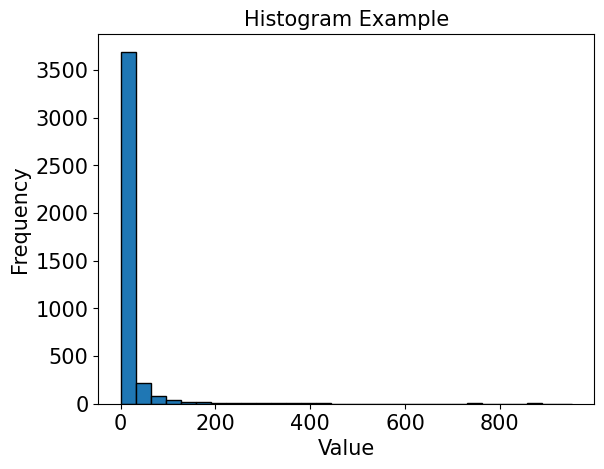

In [162]:
mask = chi2_vals < 1000*np.ones_like(chi2_vals)
chi2_vals_filtered = np.array(chi2_vals)[mask]

print(len(mask))
print(len(chi2_vals_filtered))
import numpy as np
import matplotlib.pyplot as plt

# Create histogram
plt.hist(chi2_vals_filtered, bins=30, edgecolor='black')

# Add labels
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')

# Show plot
plt.show()


In [89]:
bias_cosmology

array([[-12.74512913,  18.01062941,   0.16701642, ...,   0.80764096,
          0.02237   ,   0.9649    ],
       [ -6.82242171,  10.19435875,   0.4967719 , ...,   0.80764096,
          0.02237   ,   0.9649    ],
       [ -8.25822315,  10.98461017,   0.49728586, ...,   0.80764096,
          0.02237   ,   0.9649    ],
       ...,
       [ -3.44667745,   7.97368256,   0.28124638, ...,   0.7297337 ,
          0.02169   ,   0.9336    ],
       [ -5.46627396,   9.92790364,  -0.35646662, ...,   0.7297337 ,
          0.02169   ,   0.9336    ],
       [-12.96618403,  16.68586409,   0.30316463, ...,   0.7297337 ,
          0.02169   ,   0.9336    ]])

In [77]:
table_params

omega_b,omega_cdm,n_s,alpha_s,N_ur,w0_fld,wa_fld,log_M_0,log_M_1,gamma_1,gamma_2,sigma_c,a_1,b_0,b_1,s,Bcent,Bsat,sigma8
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.966358805717523,11.491304005087555,27.758359250612166,0.1817999719492589,0.29946412972987496,2.1453257315525462,0.41764338658764455,0.46919005302180167,-1.4234982910100635,-0.9958928233790423,0.5314856535639954,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.532922403922852,10.7058129422154,45.92447608786017,0.19186430995902687,0.33087740494524165,9.526682642636866,-0.8422003040223387,0.23120780277547726,-1.1628014686756258,0.097662369654818,0.24913445889857355,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.23157113957962,10.982567547008339,24.913701696264976,0.4255928232848277,0.19103656881174852,8.199132913528521,0.20022448645538427,-0.5355911729266001,-1.133828887183359,-0.0162907139947015,-0.6272690855196106,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,11.017364504074513,11.14460742306233,20.173169748424247,0.05860146308890926,0.29937597904785007,3.380871320437387,0.19999837593928593,0.23530159874334522,-1.8308010502198506,0.6645242028582004,-1.328610920111882,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.792858689691618,10.741826764219526,34.29175670112566,0.05187645140857966,0.35521828495118485,14.358432716506421,-2.899143664007017,0.27484907331209163,0.011662662291346937,-0.2198881355954716,-0.438259923968793,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.516321874737155,11.401542304765115,18.07363238174071,0.3974197080144879,0.12836708813358771,5.965067846971224,0.8120113149949443,-0.2855143422731251,-0.6288727155422,0.1368021762236955,-1.0038571736047532,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.36421233916839,10.822874318253847,25.5109551142789,0.30254376013555206,0.22426754427547255,4.386125937217534,-0.2817391254143262,0.5498351125754813,1.4630357795445628,-0.29144002837424865,1.0257782132244855,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.866204902950157,10.856208744545519,27.815997186654464,0.10757431795326118,0.22325701732302144,12.819734069684404,-2.4348504775740167,-0.22809738614659014,0.2790021743959481,0.04368092911597432,-1.1497979703176595,0.8076409582450294
0.02237,0.12,0.9649,0.0,2.0328,-1.0,0.0,10.273843709430809,10.987085716515656,20.65109048966272,0.3369503216623499,0.31157649755850964,7.308951503272822,-0.35816173710687826,0.4331973402926682,1.7129274706710782,0.46447762484369415,0.7791907775086204,0.8076409582450294


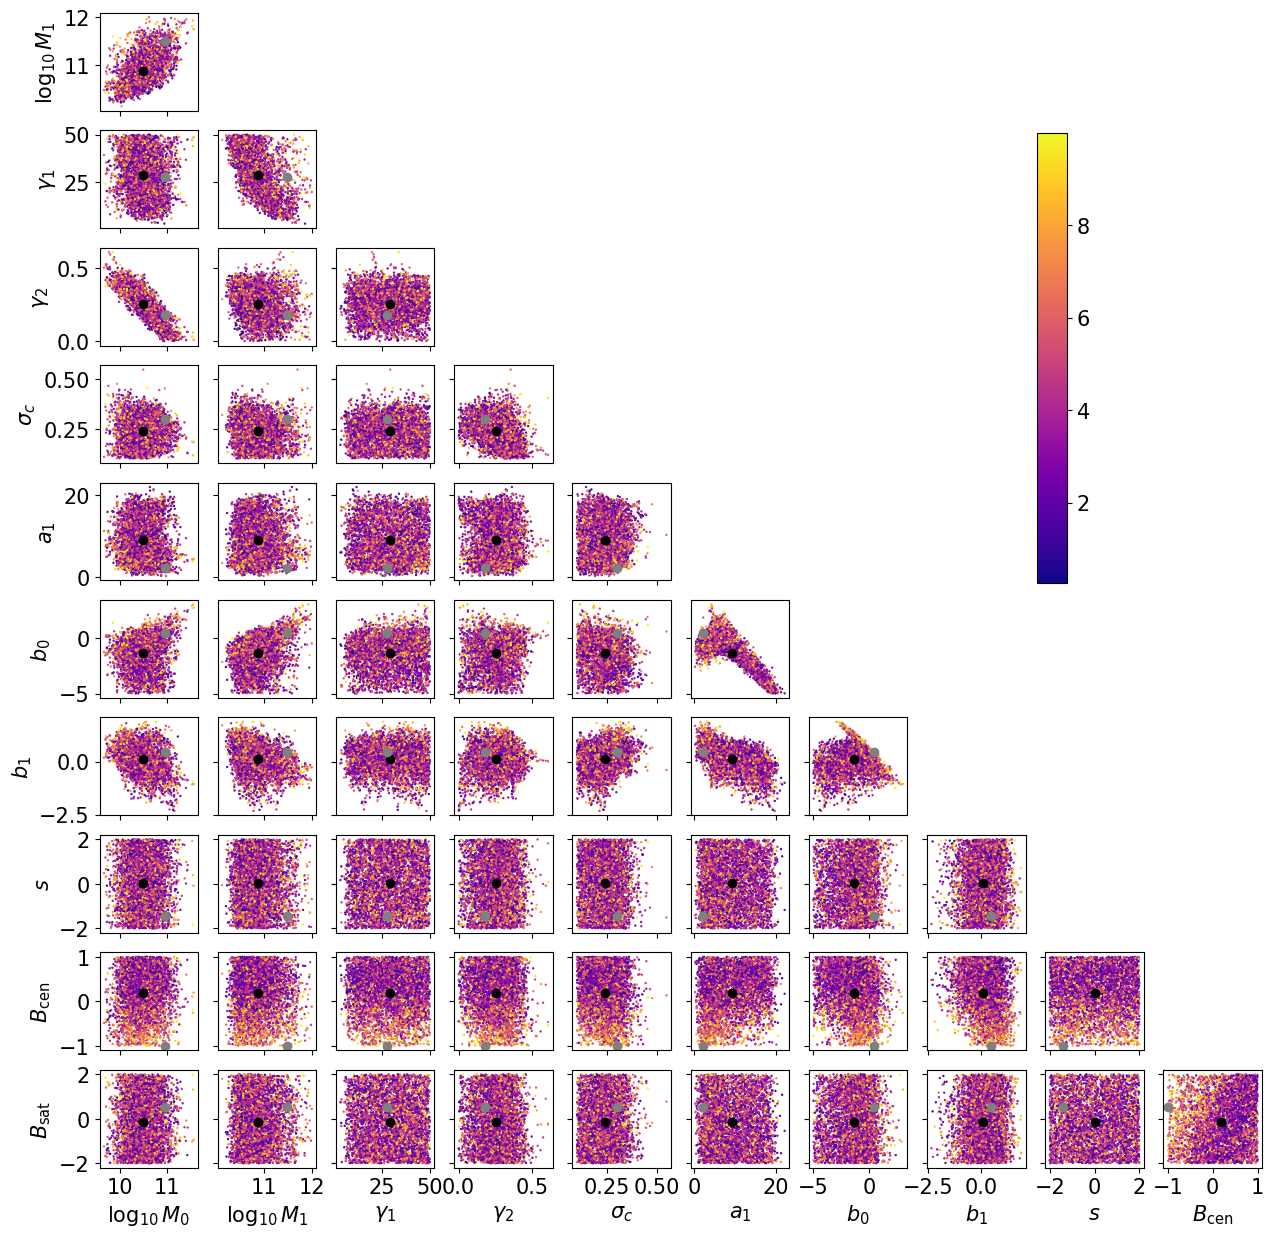

In [167]:
# Plotting parameter space for low stellar mass bin

from matplotlib import rc
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#rc('text', usetex=True)
#rc('font', family='serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

names_extended=['log_M_0', 'log_M_1', 'gamma_1', 'gamma_2', 'sigma_c', 'a_1', 'b_0', 'b_1', 's', 'Bcent', 'Bsat']
names_extended_latex=[r'$\log_{10} M_0$', r'$\log_{10} M_1$', r'$\gamma_1$', r'$\gamma_2$', r'$\sigma_c$', r'$a_1$', r'$b_0$', r'$b_1$',r'$s$', r'$B_\mathrm{cen}$', r'$B_\mathrm{sat}$']

from astropy.table import unique, Table


parameters = Table.read("parameters_4_training_100HOD.fits")[valid_fits]
#print(parameters[names_extended[0]])

chi2_vals = emulator["chi2_vals"][valid_fits]
fig, axes = plt.subplots(figsize=(15, 15),ncols=10, nrows=10)

#axes[0,0].scatter(parameters[names_extended[0]], parameters[names_extended[0+1]], s=0.1, c=bias_high, cmap='viridis', norm="linear")
#axes[0,0].set_xlabel(names_extended_latex[0],size=20)
#axes[0,0].set_ylabel(names_extended_latex[0+1],size=20)


for i in range(10):
    for j in range(10):
    
        if(i<=j):
            ax_i = axes[j,i]
            pcm = ax_i.scatter(parameters[names_extended[i]], parameters[names_extended[j+1]], s=0.5, c=chi2_vals, cmap='plasma', norm="linear")
            mean_val = ax_i.scatter(HOD_dict[names_extended[i]], HOD_dict[names_extended[j+1]], c="black")
            first_hod = ax_i.scatter(parameters[0][names_extended[i]], parameters[0][names_extended[j+1]], c="grey")
            axes[j,i].set_xlabel(names_extended_latex[i],size=15)
            axes[j,i].set_ylabel(names_extended_latex[j+1],size=15)
        elif (j > i):
            empty_ax = fig.add_subplot(j, i)
            empty_ax.axis("off")
        else:
            axes[j, i].axis('off')
for ax in axes.flat:
    ax.label_outer()

cbar_ax = fig.add_axes([0.75, 0.5, 0.02, 0.3])
fig.colorbar(pcm, cax=cbar_ax, orientation="vertical")

#plt.savefig('parameterspace_HOD_low.jpg',dpi=200,bbox_inches='tight')
plt.show()

In [112]:
type(parameters["Bcent"])

astropy.table.column.Column

In [168]:
Bcent_bounds = [-1, 1]
Bsat_bounds = [-2, 2]
log_M_0_bounds = [10.2, 10.8]
log_M_1_bounds = [10.6, 11.5]
s_bounds = [-2, 2]
sigma8_bounds = [0.7, 0.9]


parameter_bounds = parameters[:2]
for val in parameter_bounds.colnames:
    parameter_bounds[val][:] = 0
for val in parameter_bounds.colnames:
    if val == "Bcent":
        parameter_bounds[val][0] = Bcent_bounds[0]
        parameter_bounds[val][1] = Bcent_bounds[1]
    if val == "Bsat":
        parameter_bounds[val][0] = Bsat_bounds[0]
        parameter_bounds[val][1] = Bsat_bounds[1]
    if val == "log_M_0":
        parameter_bounds[val][0] = log_M_0_bounds[0]
        parameter_bounds[val][1] = log_M_0_bounds[1]
    if val == "log_M_1":
        parameter_bounds[val][0] = log_M_1_bounds[0]
        parameter_bounds[val][1] = log_M_1_bounds[1]
    if val == "s":
        parameter_bounds[val][0] = s_bounds[0]
        parameter_bounds[val][1] = s_bounds[1]
    if val == "sigma8":
        parameter_bounds[val][0] = sigma8_bounds[0]
        parameter_bounds[val][1] = sigma8_bounds[1]
print(np.min(parameters["sigma_c"]))
parameter_bounds


0.0


omega_b,omega_cdm,n_s,alpha_s,N_ur,w0_fld,wa_fld,log_M_0,log_M_1,gamma_1,gamma_2,sigma_c,a_1,b_0,b_1,s,Bcent,Bsat,sigma8
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2,10.6,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,-1.0,-2.0,0.7
0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.8,11.5,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.9


In [169]:
parameters_outside = parameters.copy()
# for val in parameters_filtered.colnames:
#     parameters_filtered[val] = parameters_filtered[val].astype(float)

parameters_outside["Bcent"] = np.where(np.logical_and(parameters_outside["Bcent"] < -1, parameters_outside["Bcent"] > 1), parameters_outside["Bcent"], np.nan)
parameters_outside["Bsat"] = np.where(np.logical_and(parameters_outside["Bsat"] < -2, parameters_outside["Bsat"] > 2), parameters_outside["Bsat"], np.nan)
parameters_outside["log_M_0"] = np.where(np.logical_and(parameters_outside["log_M_0"] < 10.2, parameters_outside["log_M_0"] > 10.8), parameters_outside["log_M_0"], np.nan)
parameters_outside["log_M_1"] = np.where(np.logical_and(parameters_outside["log_M_1"] < 10.6, parameters_outside["log_M_1"] > 11.5), parameters_outside["log_M_1"], np.nan)
parameters_outside["s"] = np.where(np.logical_and(parameters_outside["s"] < -2, parameters_outside["s"] > 2), parameters_outside["s"], np.nan)
parameters_outside["sigma8"] = np.where(np.logical_and(parameters_outside["sigma8"] < 0.7, parameters_outside["sigma8"] > 0.9), parameters_outside["sigma8"], np.nan)


In [170]:
# Setting opacity of points outside of bounds
alpha_values = parameters.copy()
for val in parameters.colnames:
    alpha = np.ones_like(parameters[val])
    alpha_values[val] = alpha

    if parameter_bounds[val][0] != 0:
        alpha[np.logical_or(parameters[val] < parameter_bounds[val][0], parameters[val] > parameter_bounds[val][1])] = 0.2 
        alpha_values[val] = alpha


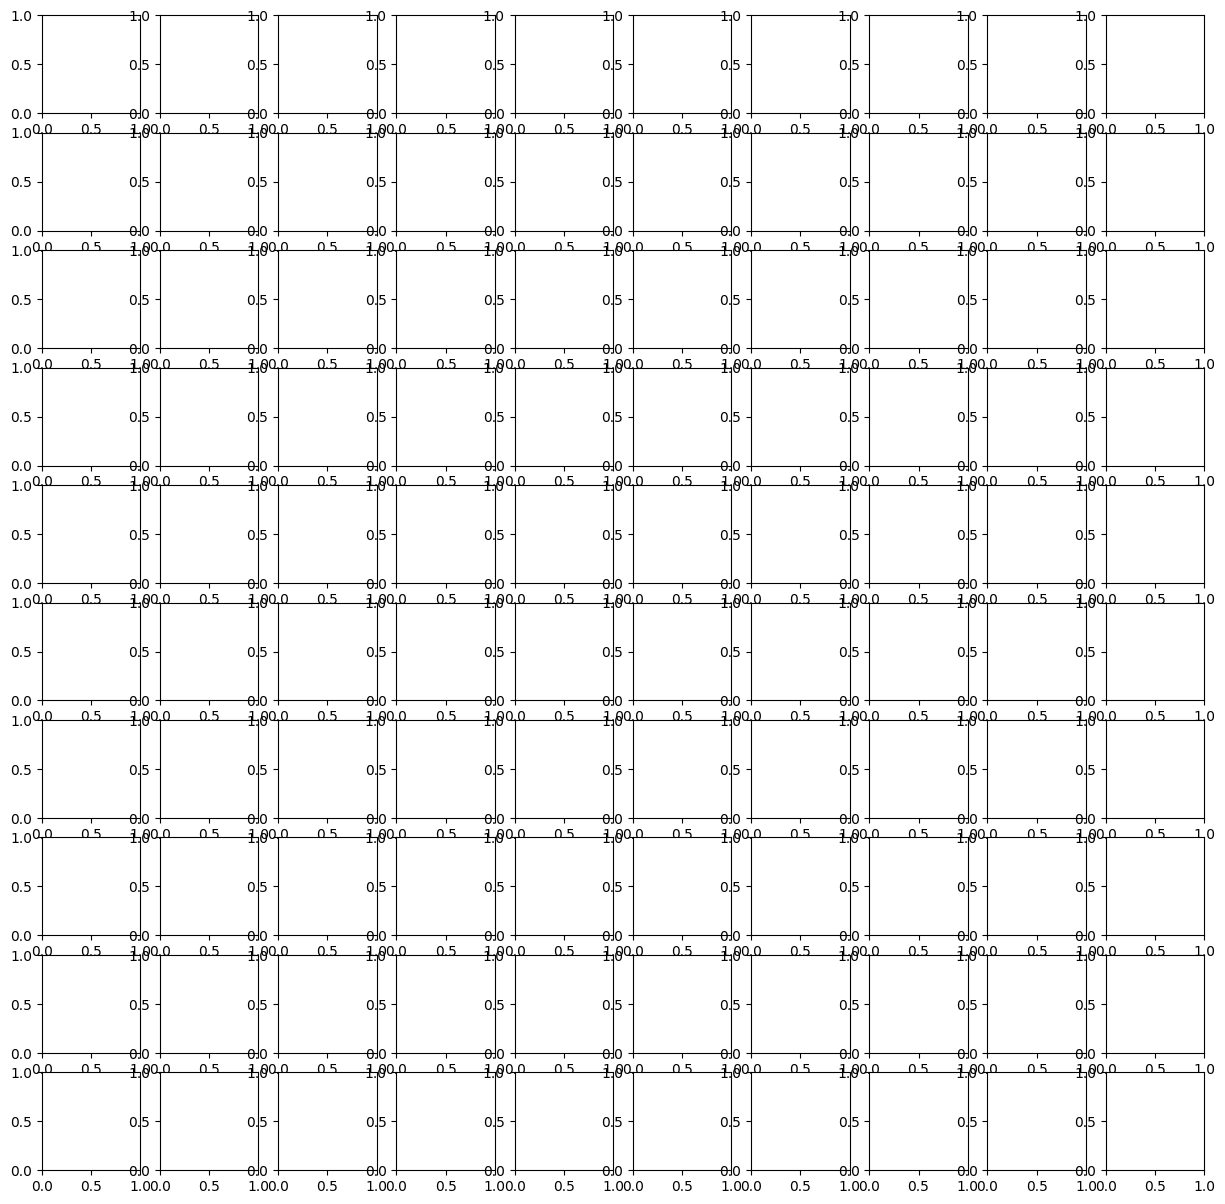

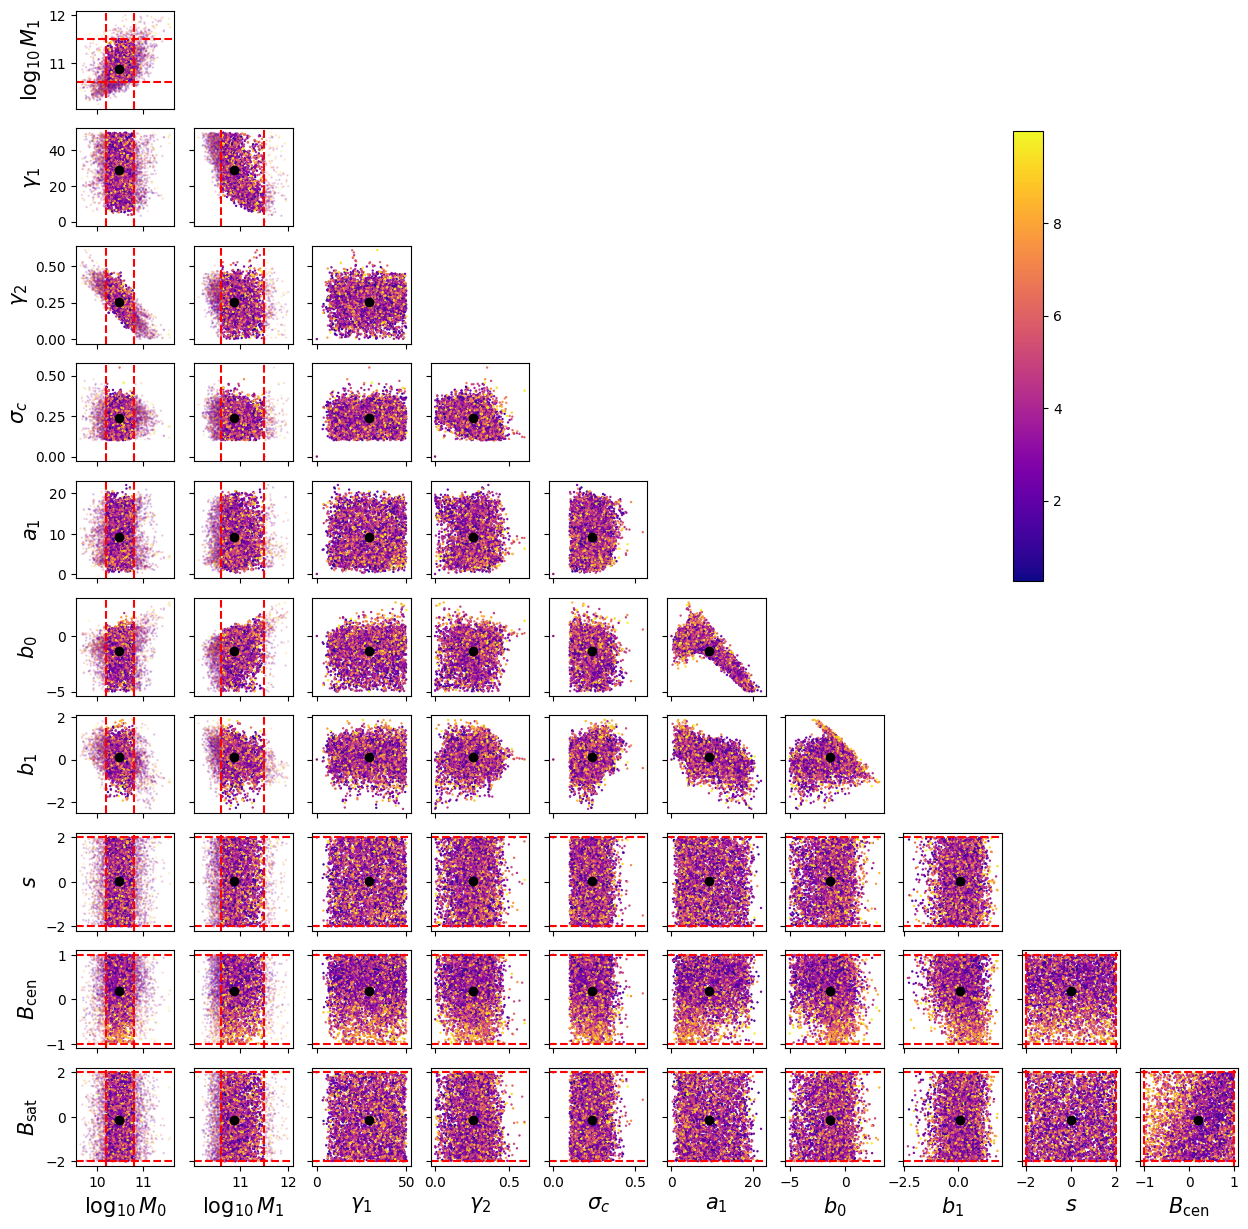

In [172]:
# Plotting parameter space for low stellar mass bin with red lines on prior

mpl.rcParams.update(mpl.rcParamsDefault)
#rc('text', usetex=True)
#rc('font', family='serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

fig, axes = plt.subplots(figsize=(15, 15),ncols=10, nrows=10)

#axes[0,0].scatter(parameters[names_extended[0]], parameters[names_extended[0+1]], s=0.1, c=bias_high, cmap='viridis', norm="linear")
#axes[0,0].set_xlabel(names_extended_latex[0],size=20)
#axes[0,0].set_ylabel(names_extended_latex[0+1],size=20)


for i in range(10):
    for j in range(10):
        a=1
        if(i<=j):
            ax_i = axes[j,i]
            alpha_bool = np.logical_or(alpha_values[names_extended[i]] == 0.2, alpha_values[names_extended[j+1]] == 0.2)
            a = np.select([alpha_bool], [0.2], default=1)    
            pcm = ax_i.scatter(parameters[names_extended[i]], parameters[names_extended[j+1]], s=0.5, c=chi2_vals, cmap='plasma', norm="linear", alpha=a)
            mean_val = ax_i.scatter(HOD_dict[names_extended[i]], HOD_dict[names_extended[j+1]], c="black")
            
            if parameter_bounds[names_extended[i]][0] != 0:
                red_left = ax_i.axvline(x=parameter_bounds[names_extended[i]][0], color='r', linestyle='--')
                red_right = ax_i.axvline(x=parameter_bounds[names_extended[i]][1], color='r', linestyle='--')
            if parameter_bounds[names_extended[j+1]][0] != 0:    
                red_top = ax_i.axhline(y=parameter_bounds[names_extended[j+1]][0], color='r', linestyle='--')
                red_bottom = ax_i.axhline(y=parameter_bounds[names_extended[j+1]][1], color='r', linestyle='--')
            
            axes[j,i].set_xlabel(names_extended_latex[i],size=15)
            axes[j,i].set_ylabel(names_extended_latex[j+1],size=15)
        elif (j > i):
            empty_ax = fig.add_subplot(j, i)
            empty_ax.axis("off")
        else:
            axes[j, i].axis('off')
for ax in axes.flat:
    ax.label_outer()

cbar_ax = fig.add_axes([0.75, 0.5, 0.02, 0.3])
fig.colorbar(pcm, cax=cbar_ax, orientation="vertical")

#plt.savefig('parameterspace_HOD_low.jpg',dpi=200,bbox_inches='tight')
plt.show()

<>:15: SyntaxWarning: invalid escape sequence '\%'
<>:16: SyntaxWarning: invalid escape sequence '\%'
<>:15: SyntaxWarning: invalid escape sequence '\%'
<>:16: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_8669/4168342702.py:15: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = '$95\%$', alpha = 0.7)
/tmp/ipykernel_8669/4168342702.py:16: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = '$68\%$', alpha = 1)


(421, 4)


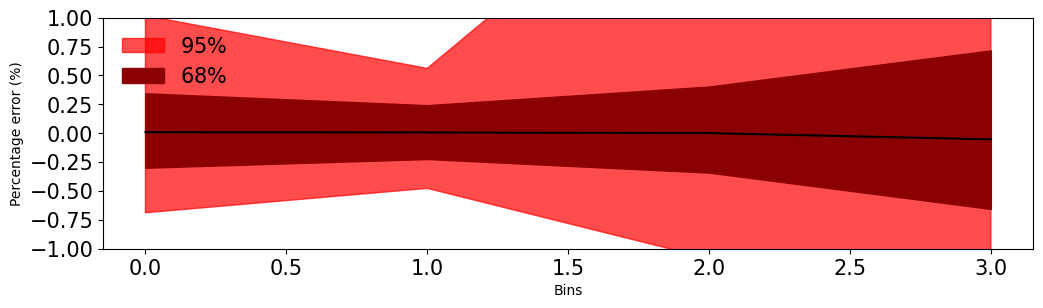

In [11]:
HOD_2_bias_emu_features = np.load("/home/akshayr/honours_thesis/School_Work/Honours_Thesis/threepoint_py_GGL/threepoint_py_GGL/HOD_2_bias_emu_features.npz")
diff=(HOD_2_bias_emu_features['test_features']/HOD_2_bias_emu_features['emu_features']-1)
print(diff.shape)
mean_diff = np.percentile(diff, 50, axis = 0)

mpl.rcParams.update(mpl.rcParamsDefault)

bins=range(diff.shape[1])
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [2.5,97.5], axis = 0)
percentiles3 = np.percentile(diff, [0.5,99.5], axis = 0)

plt.figure(figsize=(12, 3),dpi=100)
# plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = '$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black')
#plt.xscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper left')
# plt.ylabel(r'$(\langle M^2_\mathrm{ap}\rangle^{\mathrm{emu}} - \langle M^2_\mathrm{ap}\rangle^{\mathrm{true}})/  \langle M^2_\mathrm{ap}\rangle^{\mathrm{true}}$', fontsize=15)
# plt.title(r'900 nodes',size=15)

plt.xlabel("Bins")
plt.ylabel("Percentage error (%)")
plt.ylim(-1,1)
# plt.savefig('plots/emulator_accuracy_withk.jpg',dpi=400,bbox_inches='tight')
plt.show()

/tmp/ipykernel_2560/2423526181.py:15: RuntimeWarning: overflow encountered in power
  return c + a / (1 + (x / 10**x0)**(10**n))


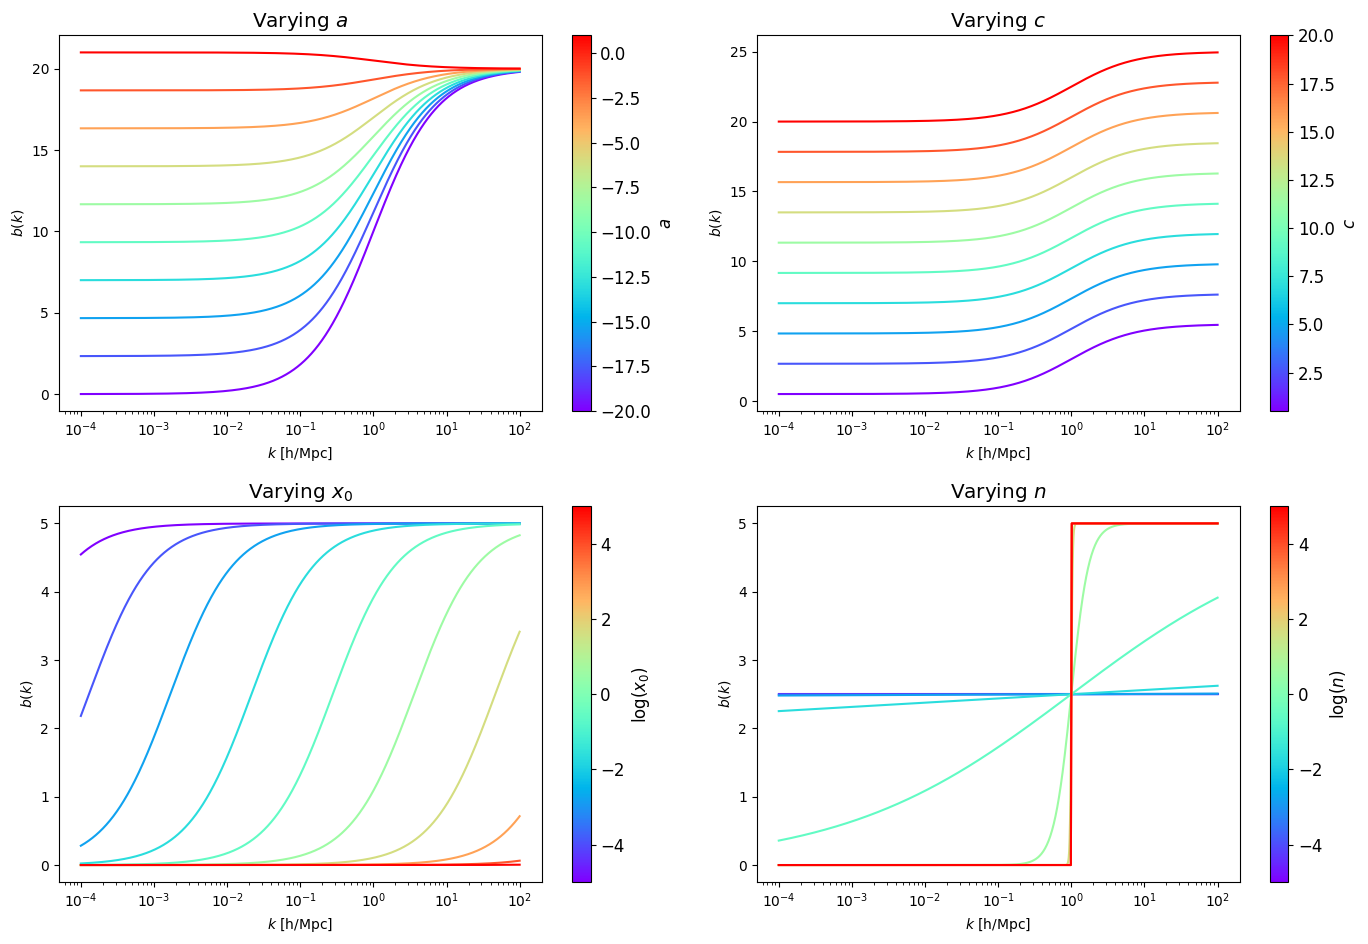

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Define the function
def flexible(x, a, c, x0, n):
    """
    Flexible function that does not converge to zero.
    - x0: transition point
    - n: sharpness of transition
    - a: amplitude factor
    - c: asymptotic offset
    """
    return c + a / (1 + (x / 10**x0)**(10**n))

# Parameters
# Define the range for x
x = np.logspace(np.log10(0.0001), np.log10(100), 1000)
# x_x0 = np.linspace(0, 0.1, 1000)

# Define fixed values for parameters
a_fixed = -5
c_fixed = 5
x0_fixed = 0
n_fixed = 0

# Define ranges for each parameter to vary
a_values = np.linspace(-20, 1, 10)
c_values = np.linspace(0.5, 20, 10)
# x0_values = np.array(list(np.linspace(-2, 0, 1000)) + list(np.linspace(0, 3, 100)))
x0_values = np.linspace(-5, 5, 10)
n_values = np.linspace(-5, 5, 10)

# Function to add colorbar
def add_colorbar(ax, sm, label):
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(label)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.rcParams.update({'font.size': 12})
# fig.suptitle('Effect of Varying Parameters on the Flexible Model Function', fontsize=16)

# Plot for varying 'a'
norm = Normalize(vmin=a_values.min(), vmax=a_values.max())
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
for a in a_values:
    y = flexible(x, a, c_fixed, x0_fixed, n_fixed)
    axes[0, 0].plot(x, y+15, label=f'a={a:.2f}', color=plt.cm.rainbow((a - a_values.min()) / (a_values.max() - a_values.min())))
add_colorbar(axes[0, 0], sm, '$a$')
axes[0, 0].set_title('Varying $a$')
axes[0, 0].set_xlabel(r'$k$ [h/Mpc]')
axes[0, 0].set_ylabel(r'$b(k)$')
axes[0, 0].set_xscale('log')

# Plot for varying 'c'
norm = Normalize(vmin=c_values.min(), vmax=c_values.max())
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
for c in c_values:
    y = flexible(x, a_fixed, c, x0_fixed, n_fixed)
    axes[0, 1].plot(x, y+5, label=f'c={c:.2f}', color=plt.cm.rainbow((c - c_values.min()) / (c_values.max() - c_values.min())))
add_colorbar(axes[0, 1], sm, '$c$')
axes[0, 1].set_title('Varying $c$')
axes[0, 1].set_xlabel(r'$k$ [h/Mpc]')
axes[0, 1].set_ylabel(r'$b(k)$')
axes[0, 1].set_xscale('log')

# Plot for varying 'x0'
norm = Normalize(vmin=x0_values.min(), vmax=x0_values.max())
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
for x0 in x0_values:
    y = flexible(x, a_fixed, c_fixed, x0, n_fixed)
    axes[1, 0].plot(x, y, label=f'x0={x0:.2f}', color=plt.cm.rainbow((x0 - x0_values.min()) / (x0_values.max() - x0_values.min())))
add_colorbar(axes[1, 0], sm, r'log($x_{0}$)')
axes[1, 0].set_title(f'Varying $x_{0}$')
axes[1, 0].set_xlabel(r'$k$ [h/Mpc]')
axes[1, 0].set_ylabel(r'$b(k)$')
axes[1, 0].set_xscale('log')

# Plot for varying 'n'
norm = Normalize(vmin=n_values.min(), vmax=n_values.max())
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
for n in n_values:
    y = flexible(x, a_fixed, c_fixed, x0_fixed, n)
    axes[1, 1].plot(x, y, label=f'n={n:.2f}', color=plt.cm.rainbow((n - n_values.min()) / (n_values.max() - n_values.min())))
axes[1, 1].set_title('Varying $n$')
axes[1, 1].set_xlabel(r'$k$ [h/Mpc]')
axes[1, 1].set_ylabel(r'$b(k)$')
axes[1, 1].set_xscale('log')
add_colorbar(axes[1, 1], sm, 'log($n$)')

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

1.9999999999


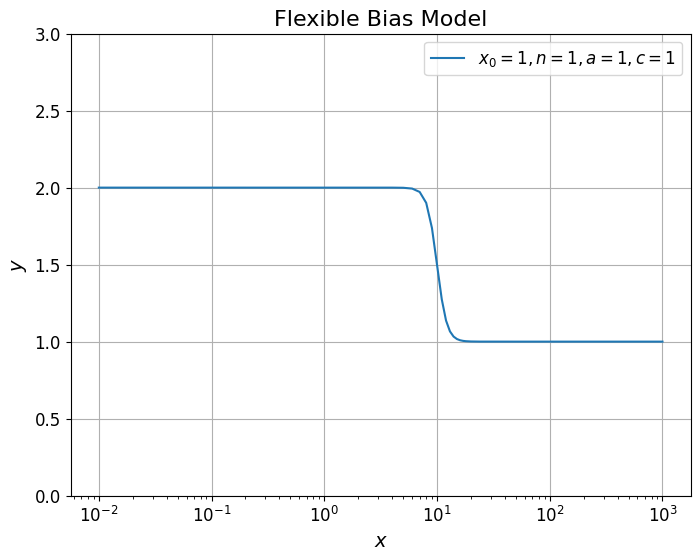

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def flexible_function_with_offset(x, a,c,x0,n):
    """
    Flexible function that does not converge to zero.
    - x0: transition point
    - n: sharpness of transition
    - a: amplitude factor
    - c: asymptotic offset
    """
    return c + a / (1 + (x / 10**x0)**(10**n))

# Parameters
x = np.linspace(0.01, 1000, 1000)
# print(x)
a=1
c=1
x0=1
n=1

# Compute the function
y = flexible_function_with_offset(x, x0=x0, n=n, a=a, c=c)
print(flexible_function_with_offset(1, x0=x0, n=n, a=a, c=c))
# Plot the function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=f'$x_0={x0}, n={n}, a={a}, c={c}$')
plt.title("Flexible Bias Model", fontsize=16)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.grid(True)
plt.ylim([0,3])
plt.xscale("log")
plt.legend(fontsize=12)
plt.show()